# Projet de conception et de programmation.

Ceci est le notebook regroupant les différentes implémentations dans le cadre du projet de conception et de programmation intitulé : Investigating feature selection techniques to improve data mining tasks.

Il est constitué de cinq parties : 
1. Une introduction au data mining.
1. Le premier chapitre sur l'explication d'une thoerie issue du data mining.
1. Le deuxième chapitre sur les algorithmes de cette thoerie
1. Le troisème chapitre d'application des algorithmes sur des dataset.
1. Une conclusion.
Et une bibliographie.

# Importations.

In [159]:
from __future__ import unicode_literals # lettre grec

import pandas as pd # DataFrame, ...
import numpy as np # array, ...
from fractions import Fraction
from itertools import combinations # combinaison
from functools import reduce
from collections import Counter
import copy

# visualistion
import seaborn as sns
from matplotlib import pyplot as plt

# imbalanced learn
# conda install -c conda-forge imbalanced-learn
# https://imbalanced-learn.org/stable/introduction.html
from imblearn.over_sampling import RandomOverSampler

# sklearn
## preprocessing
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler ,KBinsDiscretizer

##
from sklearn.neighbors import KNeighborsClassifier

## metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# fuzzy sklearn
# pip install git+https://github.com/oulenz/fuzzy-rough-learn.git
from frlearn.base import probabilities_from_scores, select_class
from frlearn.classifiers import FRNN
from frlearn.feature_preprocessors import FRFS, RangeNormaliser

# Fonctions.

## Outils.

### Fonction différence entre deux listes

In [160]:
def diff_list(list1, list2):
	"""
	Renvoie la différence entre deux listes.

	@param list1 une première liste.
	@param list2 une deuxième liste.

	@return les éléments présents dans list1 mais pas dans list2.
	"""
	# liste1 = list1.copy() if len(list1) > len(list2) else list2.copy()
	# liste2 = list1.copy() if liste1 == list2 else list2.copy()

	set_list2 = set(list2)
	diff = [x for x in list1 if x not in set_list2]
	return diff

#### Test.

In [161]:
list1 = [1, 2, 3, 4, 5]
list2 = [1, 2, 4]
diff_list(list1, list2)

[3, 5]

Les éléments 3 et 5 sont présent dans la list1 mais pas dans la list2.

In [162]:
list1 = [1, 2, 4]
list2 = [1, 2, 3, 4, 5]
diff_list(list1, list2)

[]

Tous les éléments dans la list1 sont présent dans la list2. La fonction renvoie une liste vide.

### Fonction combinaison des attributs dans un système de décision.

In [163]:
def combinaisons(DS, d):
	"""
	Renvoie la liste des combinaisons des attributs du dataframe en 
	paramètre.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return list_combinaisons La liste des combinaisons des attributs.
	"""
	list_combinaisons = list()
	C = list(DS.columns)
	C.remove(d)
	for n in range(len(C) + 1):
		list_combinaisons += list(combinations(C, n))
	list_combinaisons.remove(())
	return list_combinaisons

#### Test.

In [164]:
# création d'un dataframe
data = {
	"Patients" : ["o1", "o2", "o3", "o4", "o5", "o6"],
	"Headache" : ["Yes", "Yes", "Yes", "No", "No", "No"],
	"Muscle-pain" : ["Yes", "No", "No", "Yes", "Yes", "Yes"],
	"Temperature" : ["very high", "high", "high", "normal", "high", "very high"],
	"Flu" : ["Yes", "Yes", "No", "No", "Yes", "Yes"]
}
df = pd.DataFrame(data)

# initialisation de l'index
df.set_index("Patients", inplace=True)

# affichage des attributs
df.columns[:-1]

Index(['Headache', 'Muscle-pain', 'Temperature'], dtype='object')

La liste des combinaisons avec les attributs ci-dessus.

In [165]:
combinaisons(df, "Flu")

[('Headache',),
 ('Muscle-pain',),
 ('Temperature',),
 ('Headache', 'Muscle-pain'),
 ('Headache', 'Temperature'),
 ('Muscle-pain', 'Temperature'),
 ('Headache', 'Muscle-pain', 'Temperature')]

## Affichage.

Répartition des objets en fonction des classes.

In [166]:
def my_pie(df, class_name):
	plt.figure(figsize=(5,5))
	labels = np.unique(df[class_name].values)
	tmp = [df[df[class_name] == x] for x in labels]
	data = [len(x) for x in tmp]
	fig = plt.pie(x = data, labels = labels, autopct = '%.0f%%')
	plt.title("Répartition des objets par classes")
	plt.show()

Boxplot

In [167]:
def my_boxplot(df, attributs_plot):
	for attribut in [x for x in df.columns if x in attributs_plot]:
		sns.boxplot(x = attribut, data = df, palette = ['orange'])
		plt.show()

Matrice de correlation.

In [168]:
def my_correlation_matrix(df):
	plt.figure(figsize=(15,8))
	corr_matrix = df.corr()
	sns.heatmap(corr_matrix, annot=True)
	plt.title("Matrice de corrélation")
	plt.show()

Pairplot.

In [169]:
def my_pairplot(df, class_name):
	labels = np.unique(df[class_name].values)
	num_labels = len(labels)
	if num_labels <= 10:
		sns.pairplot(df, hue=class_name, corner = True, palette = sns.color_palette(n_colors = num_labels), height=4)
		plt.suptitle("Pair Plot", size = 40)
		plt.show()
	else :
		print("Pas assez de couleurs")

Histplot.

In [170]:
def my_histplot(df, attributs_plot, class_name):
	labels = np.unique(df[class_name].values)
	num_labels = len(labels)
	if num_labels <= 10:
		for attribut in attributs_plot:
			sns.histplot(x = attribut, data = df, kde = True, palette = sns.color_palette(n_colors = num_labels), hue = class_name)
			plt.show()
	else :
		print("Pas assez de couleurs")

Matrice de confusion.

In [171]:
def my_confusion_matrix(pred, class_name, y_test, model_name):
    labels = np.unique(df[class_name].values)
    conf_matrix = confusion_matrix(y_test, pred, labels=labels)
    df_conf_matrix = pd.DataFrame(conf_matrix, columns=labels)
    df_conf_matrix["index"] = labels
    df_conf_matrix = df_conf_matrix.set_index("index")

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Matrice de confusion pour {model_name}")
    plt.show()

Courbe d'apprentissage.

In [172]:
def my_learning_curve(model, model_name, x_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model, X=x_train, y=y_train, 
        train_sizes=np.linspace(0.1, 1.0, 4),
        n_jobs=10, verbose=0, random_state=42)

    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(model_name + ' Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

*Roc curve*.

In [173]:
def plot_roc_curve(y_true, proba, roc):
	# calculate ROC Curve
	# For the Random Model
	random_probs = [0 for _ in range(len(y_true))]
	random_fpr, random_tpr, _ = roc_curve(y_true, random_probs)
	
	# For the actual model
	model_fpr, model_tpr, _ = roc_curve(y_true, proba)
	
	# Plot the roc curve for the model and the random model line
	plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
	plt.plot(model_fpr, model_tpr, marker='.', label='Model')
	
	# Create labels for the axis
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	
	# show the legend
	plt.legend()
	
	# show the plot
	plt.show()

## Preprocessing.

Encodage.

In [174]:
def encodage(df, attributs, class_name):
	oe = OrdinalEncoder()
	df[attributs] = oe.fit_transform(df[attributs])

	le = LabelEncoder()
	df[class_name] = le.fit_transform(df[class_name])
	
	return df

Normalisation.

In [175]:
def normalisation(df, attributs):
	mm = MinMaxScaler()
	df[attributs] = mm.fit_transform(df[attributs])
	return df

Discretisation.

In [176]:
def discretisation(df):
	df["age"] = df["age"].apply(lambda x: "Young" if x < 40 else "Mid" if x <= 60 else "Old")
	df["blood pressure"] = df["blood pressure"].apply(lambda x: "Normal" if x < 139 else "Abnormal")
	df["cholestoral"] = df["cholestoral"].apply(lambda x: "Abnormal" if x < 150 else "Normal" if x <= 250 else "Abnormal")
	df["heart rate max"] = df["heart rate max"].apply(lambda x: "Low" if x < 60 else "Normal" if x <= 100 else "Hight")

	return df

## *Sampling*.

In [177]:
def sampling(df, attributs, class_name):
	X = df[attributs].values
	y = df[class_name].values

	ros = RandomOverSampler(random_state=0)
	X_sample, y_sample = ros.fit_resample(X, y)

	data_sample = np.concatenate((X_sample, y_sample.reshape(-1,1)), axis=1)
	df_sample = pd.DataFrame(data_sample, columns=attributs + [class_name])
	return df_sample

# Chapitre 3: Implémentation et tests.

## Jeu de test.

In [178]:
data = {
	"Patients" : ["o1", "o2", "o3", "o4", "o5", "o6"],
	"Headache" : ["Yes", "Yes", "Yes", "No", "No", "No"],
	"Muscle-pain" : ["Yes", "No", "No", "Yes", "Yes", "Yes"],
	"Temperature" : ["very high", "high", "high", "normal", "high", "very high"],
	"Flu" : ["Yes", "Yes", "No", "No", "Yes", "Yes"]
}

df = pd.DataFrame(data)
df.set_index("Patients", inplace=True)
df

,Headache,Muscle-pain,Temperature,Flu
Patients,,,,
o1,Yes,Yes,very high,Yes
o2,Yes,No,high,Yes
o3,Yes,No,high,No
o4,No,Yes,normal,No
o5,No,Yes,high,Yes
o6,No,Yes,very high,Yes


In [179]:
data2 = {
	"x" : ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"],
	"a" : [1, 0, 2, 1, 1, 2, 2, 0],
	"b" : [0, 1, 2, 1, 0, 2, 1, 1],
	"c" : [2, 1, 0, 0, 2, 0, 1, 1],
	"d" : [2, 1, 1, 2, 0, 1, 1, 1],
	"e" : [0, 2, 1, 2, 1, 1, 2, 1],
}

df2 = pd.DataFrame(data2)
df2.set_index("x", inplace=True)
df2

,a,b,c,d,e
x,,,,,
x1,1,0,2,2,0
x2,0,1,1,1,2
x3,2,2,0,1,1
x4,1,1,0,2,2
x5,1,0,2,0,1
x6,2,2,0,1,1
x7,2,1,1,1,2
x8,0,1,1,1,1


## *Indiscernibility Relation*.

### Implémentation.

In [180]:
def IND(DS, d, C):
	"""
	Calcule la Indiscernibility Relation pour un attribut.
	
	@param DS le système de décision.
	@param d la décision.
	@param C La liste des attributs.
	
	@return ind la Indiscernibility Relation.
	"""
	ind = []
	IS = DS.drop(d, axis=1)
	group = IS.groupby(C)

	for g in group:
		gDS = pd.DataFrame(g[1])
		ind.append(list(gDS.index))
	ind.sort()
	return ind

### Test.

On regroupe les objets possèdants les même valeurs pour l'attribut "Headache".

In [181]:
ind = IND(df, "Flu", ["Headache"])
ind

[['o1', 'o2', 'o3'], ['o4', 'o5', 'o6']]

On regroupe les objets possèdants les même valeurs pour l'ensemble d'attribut {"Headache", "Muscle-pain"}.

In [182]:
ind2 = IND(df, "Flu", ["Headache", "Muscle-pain"])
ind2

[['o1'], ['o2', 'o3'], ['o4', 'o5', 'o6']]

### Implémentation 2.

In [183]:
def IND_C(DS, d):
	"""
	Calcule la Indiscernibility Relation pour tous les
	attributs du système de décision.
	
	@param DS le système de décision.
	@param d la décision.
	
	@return ind_c la Indiscernibility Relation.
	"""
	ind = []
	IS = DS.drop(d, axis=1)
	group = IS.groupby(list(IS.columns))

	for g in group:
		gDS = pd.DataFrame(g[1])
		ind.append(list(gDS.index))
	ind.sort()
	return ind

### Test.

On regroupe les objets ayant les même valeurs pour tous les attributs.

In [184]:
ind_c = IND_C(df, "Flu")
ind_c

[['o1'], ['o2', 'o3'], ['o4'], ['o5'], ['o6']]

In [185]:
ind_c2 = IND_C(df2, "e")
ind_c2

[['x1'], ['x2', 'x8'], ['x3', 'x6'], ['x4'], ['x5'], ['x7']]

### Fonction groupe_ind_c_obj

### Implémentation.

In [186]:
def groupe_ind_c_obj(ind_c, obj):
	"""
	Renvoie le groupe indiscernable de l'objet obj sans ce dernier.

	@param ind_c la liste des objets indiscernable.
	@param obj l'index d'un objet.

	@return le groupe indiscernable de l'objet.
	"""
	for g in ind_c:
		for obj2 in g:
			if obj == obj2:
				copy_g = g.copy()
				copy_g.remove(obj)
				return copy_g
	return []

### Test.

On affiche les objets qui sont dans le même groupe indiscernable. Si le retour est vide c'est que l'objet ne possède est seul dasn son groupe, i.e il ne n'existe pas d'objet indiscernable à cette objet.

On cherche le groupe indiscernable de o3 qui est [o2, o3], la fonction nous renvoie uniquement [o3].

In [187]:
groupe_ind_c_obj(ind_c, "o3")

['o2']

On cherche le groupe indiscernable de o1 qui est [o1], la fonction nous renvoie une liste vide.

In [188]:
groupe_ind_c_obj(ind_c, "o1")

[]

On cherche le groupe indiscernable de x8 qui est [x2, x8], la fonction nous renvoie uniquement [x8].

In [189]:
groupe_ind_c_obj(ind_c2, "x8")

['x2']

## *B-lower approximation*.

### Implémentation.

In [190]:
def b_lower(DS, ind_c, d, d_value):
    """
    Renvoie la B-lower approximation.

    @param DS le système de décision.
    @param ind_c la liste des objets indiscernables.
    @param d le nom de la colonne de décision.
    @param d_value la valeur de décision.

    @return la B-lower approximation.
    """
    X = DS.groupby(d)
    Xi = None
    for name, groupe in X:
        if name == d_value:
            Xi = pd.DataFrame(groupe)

    if Xi is not None:
        CXi = []

        for index in Xi.index:
            # Nous regardons le groupe indiscernable de cet objet.
            idc_obj = groupe_ind_c_obj(ind_c, index)
            
            # Si aucun des objets indiscernables de cet objet n'a une décision différente.
            if not any(DS.at[index_obj2, d] != DS.at[index, d] for index_obj2 in idc_obj):
                CXi.append(index)
        CXi.sort()
        return CXi
    else:
        return "error"

### Test.

On rend tous les objets tel que la décision "Flu" soit égal à "Yes" et pour chaque objet on le supprime si il un existe un objet identique mais qui ne possède pas le même valeur de décision (ici "No").

In [191]:
blower_yes = b_lower(df, ind_c, "Flu", "Yes")
blower_yes

['o1', 'o5', 'o6']

On rend tous les objets tel que la décision "Flu" soit égal à "No" et pour chaque objet on le supprime si il un existe un objet identique mais qui ne possède pas le même valeur de décision (ici "Yes").

In [192]:
blower_no = b_lower(df, ind_c, "Flu", "No")
blower_no

['o4']

## *B-upper approximation*.

### Implémentation.

In [193]:
def b_upper(DS, ind_c, d, d_value):
    """
    Renvoie la B-upper approximation.

    @param DS le système de décision.
    @param ind_c la liste des objets indiscernables.
    @param d le nom de la colonne de décision.
    @param d_value la valeur de décision.

    @return la B-upper approximation.
    """
    X = DS.groupby(d)
    Xi = None
    for name, groupe in X:
        if name == d_value:
            Xi = pd.DataFrame(groupe)

    if Xi is not None:
        CXi = list(Xi.index)
        for index in Xi.index:
            # Nous regardons le groupe indiscernable de cet objet.
            idc_obj = groupe_ind_c_obj(ind_c, index)
            
            # Si il possède des objets indiscernables.
            list_add = [index_obj2 for index_obj2 in idc_obj
                        if DS.at[index_obj2, d] != DS.at[index, d]]
            CXi += list_add
        CXi.sort()
        return CXi
    else:
        return "error"

### Test.

On rend tous les objets tel que la décision "Flu" soit égal à "Yes" et pour chaque objet on ajout les objets indiscernables à ce dernier.

In [194]:
bupper_yes = b_upper(df, ind_c, "Flu", "Yes")
bupper_yes

['o1', 'o2', 'o3', 'o5', 'o6']

On rend tous les objets tel que la décision "Flu" soit égal à "No" et pour chaque objet on ajout les objets indiscernables à ce dernier.

In [195]:
bupper_no = b_upper(df, ind_c, "Flu", "No")
bupper_no

['o2', 'o3', 'o4']

## *B-boundary region*.

### Implémentation.

In [196]:
def b_boundary(DS, bupper, blower):
	"""
	Calcule la B-boundary region.

	@param DS le système de décision.
	@param bupper la B-upper approximation.
	@param blower la B-lower approximation.

	@return la différence entre les deux approximations.
	"""
	return diff_list(bupper, blower)

### Test.

bupper_yes = ['o1', 'o2', 'o3', 'o5', 'o6']

blower_yes = ['o1', 'o5', 'o6']

Les éléments qui sont présents dans bupper_yes mais pas dans blower_yes sont o2 et o3.

In [197]:
b_boundary(df, bupper_yes, blower_yes)

['o2', 'o3']

bupper_no = ['o2', 'o3', 'o4']

blower_no = ['o4']

Les éléments qui sont présents dans bupper_no mais pas dans blower_no sont o2 et o3.

In [198]:
b_boundary(df, bupper_no, blower_no)

['o2', 'o3']

## *Positive Region*.

### Implémentation.

In [199]:
def POS(DS, d, C):
	"""
	Calcul la Positive Region avec les C attributs.

	@param DS Le système de décision.
	@param d La colonne de décision.
	@param C La liste des attributs.

	@return La Positive region des C attributs.
	"""
	attr = C.copy()
	attr.append(d)
	ds = DS[attr]
	ind = IND(ds, d, C)
	d_values = list(ds[d])
	d_values = [*set(d_values)]
	POS = []
	for d_value in d_values:
		POS += b_lower(ds, ind, d, d_value)
	POS.sort()
	return POS

### Test.

Nous calculons la POS pour toutes les combinaisons d'attributs.

In [200]:
for combi in combinaisons(df, "Flu"):
	liste_combi = list(combi)
	print("POS{{{}}} = {}".format(liste_combi, POS(df, "Flu", liste_combi)))

POS{['Headache']} = []
POS{['Muscle-pain']} = []
POS{['Temperature']} = ['o1', 'o4', 'o6']
POS{['Headache', 'Muscle-pain']} = ['o1']
POS{['Headache', 'Temperature']} = ['o1', 'o4', 'o5', 'o6']
POS{['Muscle-pain', 'Temperature']} = ['o1', 'o4', 'o5', 'o6']
POS{['Headache', 'Muscle-pain', 'Temperature']} = ['o1', 'o4', 'o5', 'o6']


### Implémentation 2.

In [201]:
def POS_C(DS, d):
	"""
	Calcule la Positive Region avec tous les attributs.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return La Positive region de tous les attributs.
	"""
	d_values = list(DS[d])
	d_values = [*set(d_values)]
	POS_C = []
	ind_c = IND_C(DS, d)
	for d_value in d_values:
		blower = b_lower(DS, ind_c, d, d_value)
		POS_C += blower
	POS_C.sort()
	return POS_C

### Test.

Nous calculons la POS pour tous les attributs.

In [202]:
POS_C(df, "Flu")

['o1', 'o4', 'o5', 'o6']

In [203]:
POS_C(df2, "e")

['x1', 'x3', 'x4', 'x5', 'x6', 'x7']

## *Negative Region*.

### Implémentation.

In [204]:
def NEG_C(DS, d):
	"""
	Calcule la Negative Region avec tous les attributs.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return La Negative region de tous les attributs.
	"""
	d_values = list(DS[d])
	d_values = [*set(d_values)]
	NEG_C = []
	ind_c = IND_C(DS, d)
	for d_value in d_values:
		NEG_C += b_upper(DS, ind_c, d, d_value)
	NEG_C = [*set(NEG_C)]
	neg = diff_list(list(DS.index), NEG_C)
	neg.sort()
	return neg

### Test.

In [205]:
NEG_C(df, "Flu")

[]

In [206]:
NEG_C(df2, "e")

[]

## *Reduct*.

### Implémentation.

In [207]:
def reduct(DS, d):
	"""
	Renvoie toutes les réductions d'attributs possibles.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return reducts : La liste des réductions.
	"""
	reducts = []
	pos_c = POS_C(DS, d)
	# print("pos_c", pos_c)
	C = list(DS.columns)
	C.remove(d)
	for combi in combinaisons(DS, d):
		liste_combi = list(combi)
		if liste_combi != C:
			pos = POS(DS, d, liste_combi)
			# print("POS({}) = {}".format(liste_combi, pos))
			if pos == pos_c:
				# print("reduct possible", liste_combi)
				print("Un reduct trouvé !")
				reducts.append(liste_combi)
	reducts.sort()

	len_reducts = [len(x) for x in reducts]
	reduc_by_len = Counter(len_reducts)
	print(reduc_by_len)

	if len(reducts)!= 0:
		# On garde les plus petites reductions
		print("Selection des reducts minimaux...")
		min_len = min([len(x) for x in reducts])
		reducts = [x for x in reducts if len(x) == min_len]

	len(reducts) == 0 and print("Aucun reduct trouvé")
	return reducts

### Test.

In [208]:
reducts = reduct(df, "Flu")
reducts

Un reduct trouvé !
Un reduct trouvé !
Counter({2: 2})
Selection des reducts minimaux...


[['Headache', 'Temperature'], ['Muscle-pain', 'Temperature']]

In [209]:
# création d'un dataframe
data3 = {
	"x" : ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"],
	"a" : [1, 0, 2, 1, 1, 2, 2, 0],
	"b" : [0, 1, 0, 1, 0, 2, 1, 1],
	"c" : [2, 1, 0, 0, 2, 0, 1, 1],
	"d" : [2, 1, 1, 2, 0, 1, 1, 0],
	"e" : [0, 2, 1, 2, 1, 1, 2, 1],
}

df3 = pd.DataFrame(data3)
df3.set_index("x", inplace=True)
df3

,a,b,c,d,e
x,,,,,
x1,1,0,2,2,0
x2,0,1,1,1,2
x3,2,0,0,1,1
x4,1,1,0,2,2
x5,1,0,2,0,1
x6,2,2,0,1,1
x7,2,1,1,1,2
x8,0,1,1,0,1


In [210]:
reduct(df3, "e")

Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Counter({3: 3, 2: 2})
Selection des reducts minimaux...


[['b', 'd'], ['c', 'd']]

## *Core*.

### Implémentation.

In [211]:
def core(reducts):
	"""
	Calcul l'intersection de toutes les réductions.

	@param reducts la liste des réductions.

	@return le core du système de décision.
	"""
	return list(reduce(lambda i, j: i & j, (set(x) for x in reducts)))

### Test.

In [212]:
core(reducts)

['Temperature']

## Dépendance des attributs.

### Implémentation.

In [213]:
def dependance_attributs(DS, C, d):
	"""
	Calcul la dépendance des attributs.

	@param DS Le système de décision.
	@param C la liste des attributs.
	@param d la colonne de décision.

	@return la dépendance des attributs.
	"""
	ds = DS[C]
	if len(list(ds.columns)) == 1 and list(ds.columns)[0] == d:
		return 0
	ind_c = IND_C(ds, d)
	pos_c = POS_C(ds, d)
	# dep = Fraction(len(pos_c), len(ds.index))
	dep = float(len(pos_c)) / len(ds.index)
	return dep

In [214]:
def dependance_attributs2(DS, C, d):
    ds = DS[C]
    ind_c = IND_C(ds, d)
    pos_c = POS_C(ds, d)
    dep = sum(pos_c) / len(ds.index)
    return dep

## *QuickReduct*.

### Implémentation.

In [215]:
def quickReduct(DS, d):
	"""
	L'algorithme de quickReduct.

	@param DS Le système de décision.
	@param d la colonne de décision.

	@return une sous liste d'attributs.
	"""
	C = list(DS.columns)
	C.remove(d)
	print("C :", C)
	# calcul de lambda C.
	dep_C = dependance_attributs(DS, DS.columns, d)
	print("λC :", dep_C, "\n")
	R = []
	while True:
		T = R
		# calcul de lambda T.
		attr = T.copy() + [d]
		dep_T = dependance_attributs(DS, attr, d)
		print("λT({}) = {}".format(attr[:-1], dep_T))
		
		# calcul de C - R.
		C_R = diff_list(C, R)
		print("C_R", C_R)
		
		# parcours des attributs.
		changement_t = False
		for x in C_R:
			print("x :", x)
			# calcul de lambda RU{x}.
			attr2 = R.copy() + [x, d]
			dep_RUx = dependance_attributs(DS, attr2, d)
			print("λRUx({}) = {}".format(attr2[:-1], dep_RUx))
			
			# changement meilleur dépendance.
			if dep_RUx > dep_T:
				T = R.copy() + [x]
				print("changement R =", T)
				attr3 = T.copy() + [d]
				dep_T = dependance_attributs(DS, attr3, d)
				changement_t = True

		if not changement_t:
			return "error"
		
		R = T.copy()
		# calcul de lambda R.
		attr4 = R.copy() + [d]
		dep_R = dependance_attributs(DS, attr4, d)
		print("λR({}) = {}".format(attr4[:-1], dep_R))
		if dep_R == dep_C:
			return R

### Test.

In [216]:
quickReduct(df, "Flu")

C : ['Headache', 'Muscle-pain', 'Temperature']
λC : 0.6666666666666666 

λT([]) = 0
C_R ['Headache', 'Muscle-pain', 'Temperature']
x : Headache
λRUx(['Headache']) = 0.0
x : Muscle-pain
λRUx(['Muscle-pain']) = 0.0
x : Temperature
λRUx(['Temperature']) = 0.5
changement R = ['Temperature']
λR(['Temperature']) = 0.5
λT(['Temperature']) = 0.5
C_R ['Headache', 'Muscle-pain']
x : Headache
λRUx(['Temperature', 'Headache']) = 0.6666666666666666
changement R = ['Temperature', 'Headache']
x : Muscle-pain
λRUx(['Temperature', 'Muscle-pain']) = 0.6666666666666666
λR(['Temperature', 'Headache']) = 0.6666666666666666


['Temperature', 'Headache']

2ème test.

In [217]:
data2 = {
	"x" : ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"],
	"a" : [1, 0, 2, 1, 0, 1, 2, 1],
	"b" : [2, 3, 3, 1, 2, 1, 2, 2],
	"c" : [4, 3, 1, 2, 0, 2, 1, 0],
	"d" : [0, 2, 3, 1, 1, 4, 3, 2],
	"e" : [1, 1, 3, 2, 2, 3, 2, 2],
	"X" : [1, 2, 2, 1, 1, 2, 2, 1],
}

df2 = pd.DataFrame(data2)
df2.set_index("x", inplace=True)
df2

,a,b,c,d,e,X
x,,,,,,
x1,1,2,4,0,1,1
x2,0,3,3,2,1,2
x3,2,3,1,3,3,2
x4,1,1,2,1,2,1
x5,0,2,0,1,2,1
x6,1,1,2,4,3,2
x7,2,2,1,3,2,2
x8,1,2,0,2,2,1


In [218]:
quickReduct(df2, "X")

C : ['a', 'b', 'c', 'd', 'e']
λC : 1.0 

λT([]) = 0
C_R ['a', 'b', 'c', 'd', 'e']
x : a
λRUx(['a']) = 0.25
changement R = ['a']
x : b
λRUx(['b']) = 0.25
x : c
λRUx(['c']) = 0.75
changement R = ['c']
x : d
λRUx(['d']) = 0.75
x : e
λRUx(['e']) = 0.25
λR(['c']) = 0.75
λT(['c']) = 0.75
C_R ['a', 'b', 'd', 'e']
x : a
λRUx(['c', 'a']) = 0.75
x : b
λRUx(['c', 'b']) = 0.75
x : d
λRUx(['c', 'd']) = 1.0
changement R = ['c', 'd']
x : e
λRUx(['c', 'e']) = 1.0
λR(['c', 'd']) = 1.0


['c', 'd']

# Chapitre 4:  Applications

## Chargement du dataset.

Lien : https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29

In [219]:
names = [
	"age", 
	"sex", 
	"chest pain type", 
	"blood pressure", 
	"cholestoral",
	"blood sugar",
	"electrocardiographic",
	"heart rate max",
	"angina",
	"oldpeak",
	"peak exercise",
	"vessels",
	"thal",
	"heart disease"
]

df = pd.read_csv("data/heart.dat", sep=" ", names=names)
df

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal,heart disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0,1
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0,1
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,1
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0,1


In [220]:
attributs = df.columns.to_list()
attributs.remove("heart disease")
class_name = "heart disease"
"attributs", attributs, "classe", class_name

('attributs',
 ['age',
  'sex',
  'chest pain type',
  'blood pressure',
  'cholestoral',
  'blood sugar',
  'electrocardiographic',
  'heart rate max',
  'angina',
  'oldpeak',
  'peak exercise',
  'vessels',
  'thal'],
 'classe',
 'heart disease')

Informations sur les données du dataset.

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   270 non-null    float64
 1   sex                   270 non-null    float64
 2   chest pain type       270 non-null    float64
 3   blood pressure        270 non-null    float64
 4   cholestoral           270 non-null    float64
 5   blood sugar           270 non-null    float64
 6   electrocardiographic  270 non-null    float64
 7   heart rate max        270 non-null    float64
 8   angina                270 non-null    float64
 9   oldpeak               270 non-null    float64
 10  peak exercise         270 non-null    float64
 11  vessels               270 non-null    float64
 12  thal                  270 non-null    float64
 13  heart disease         270 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 29.7 KB


Type des attributs.

In [222]:
df.dtypes

age                     float64
sex                     float64
chest pain type         float64
blood pressure          float64
cholestoral             float64
blood sugar             float64
electrocardiographic    float64
heart rate max          float64
angina                  float64
oldpeak                 float64
peak exercise           float64
vessels                 float64
thal                    float64
heart disease             int64
dtype: object

Discretisation.

In [223]:
df = discretisation(df)
df

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal,heart disease
0,Old,1.0,4.0,Normal,Abnormal,0.0,2.0,Hight,0.0,2.4,2.0,3.0,3.0,2
1,Old,0.0,3.0,Normal,Abnormal,0.0,2.0,Hight,0.0,1.6,2.0,0.0,7.0,1
2,Mid,1.0,2.0,Normal,Abnormal,0.0,0.0,Hight,0.0,0.3,1.0,0.0,7.0,2
3,Old,1.0,4.0,Normal,Abnormal,0.0,0.0,Hight,1.0,0.2,2.0,1.0,7.0,1
4,Old,0.0,2.0,Normal,Abnormal,0.0,2.0,Hight,1.0,0.2,1.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Mid,1.0,3.0,Abnormal,Normal,1.0,0.0,Hight,0.0,0.5,1.0,0.0,7.0,1
266,Mid,1.0,2.0,Normal,Abnormal,0.0,0.0,Hight,0.0,0.0,1.0,0.0,7.0,1
267,Mid,0.0,2.0,Abnormal,Abnormal,0.0,2.0,Hight,0.0,1.3,2.0,0.0,3.0,1
268,Mid,1.0,4.0,Abnormal,Normal,0.0,0.0,Hight,0.0,0.4,2.0,0.0,6.0,1


Reducts.

In [224]:
# reduct(df, class_name)

## *Preprocessing*.

In [225]:
df_prepro = copy.deepcopy(df)

### Encodage.

In [226]:
df_prepro = encodage(df_prepro, attributs, class_name)
df_prepro

,age,sex,chest pain type,blood pressure,cholestoral,blood sugar,electrocardiographic,heart rate max,angina,oldpeak,peak exercise,vessels,thal,heart disease
0,1.0,1.0,3.0,1.0,0.0,0.0,2.0,0.0,0.0,23.0,1.0,3.0,0.0,1
1,1.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,16.0,1.0,0.0,2.0,0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,1
3,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,0
4,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0
266,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
267,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,13.0,1.0,0.0,0.0,0
268,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0


## *Data visualization*.

Nombre d'instances par classes.

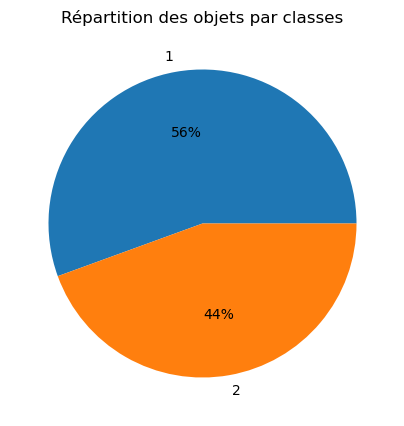

In [227]:
my_pie(df, class_name)

Matrice de corrélation.

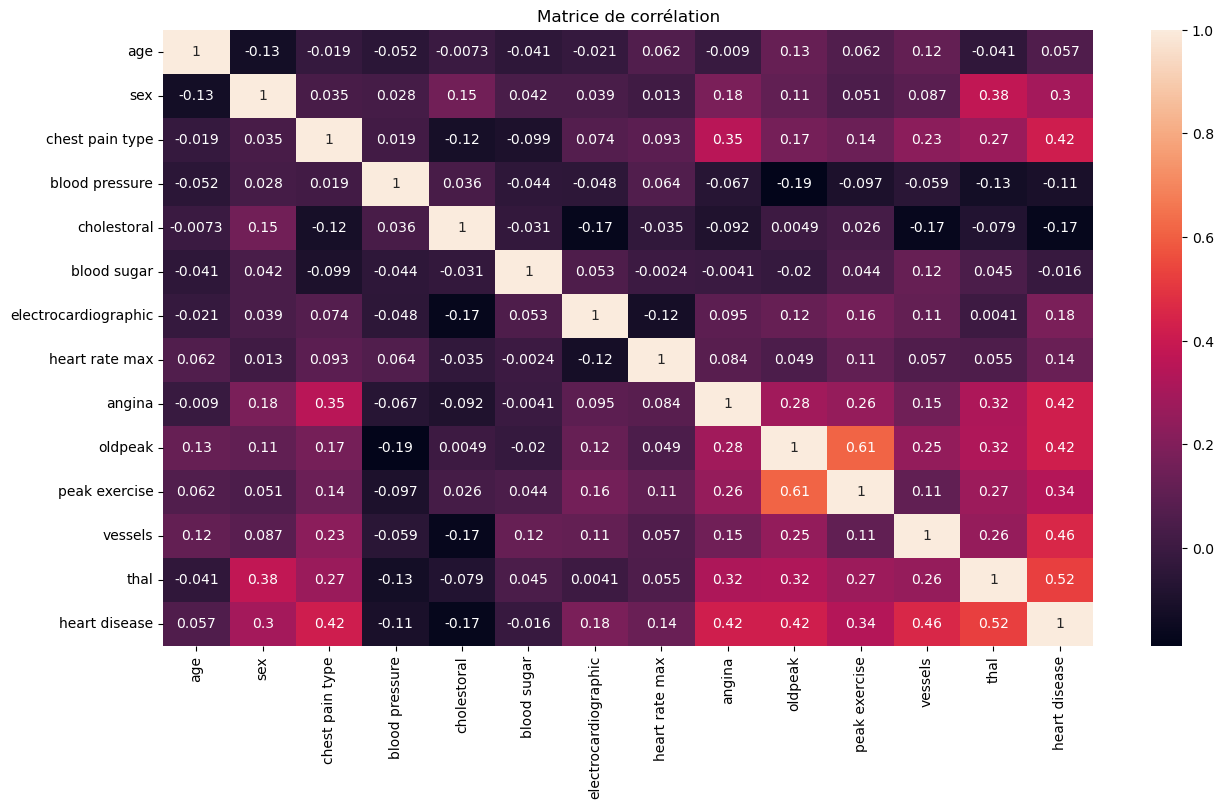

In [228]:
my_correlation_matrix(df_prepro)

Boxplot.

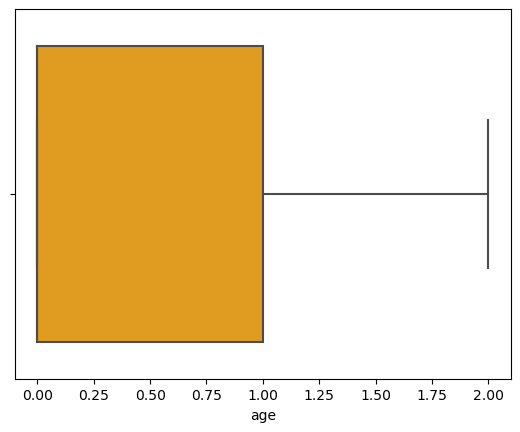

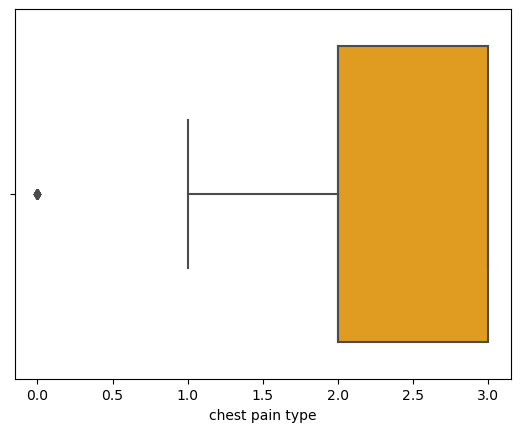

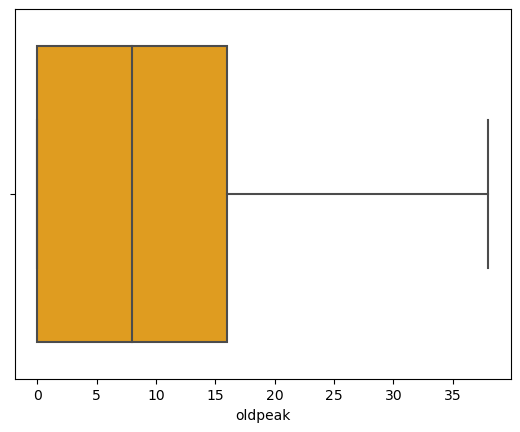

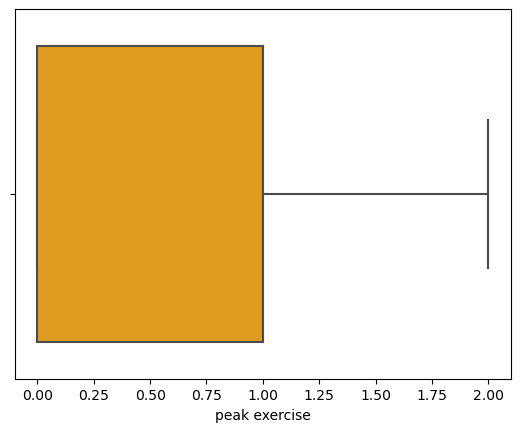

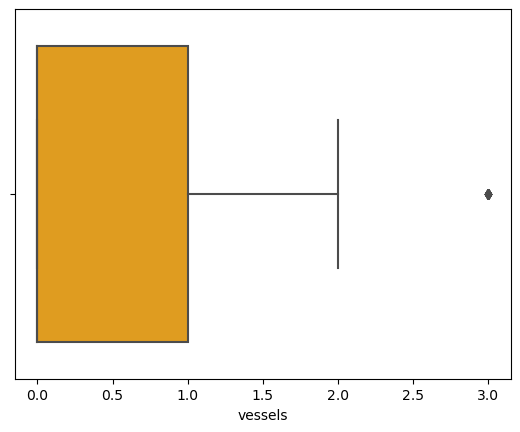

In [229]:
attributs_utils = [
	"age",
	"chest pain type",
	"oldpeak",
	"peak exercise",
	"vessels"
]
my_boxplot(df_prepro, attributs_utils)

Histplot.

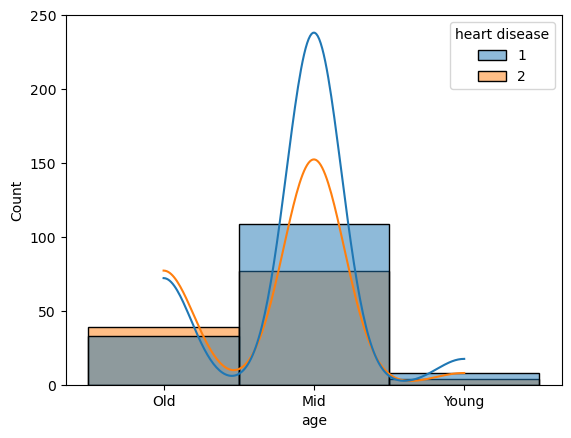

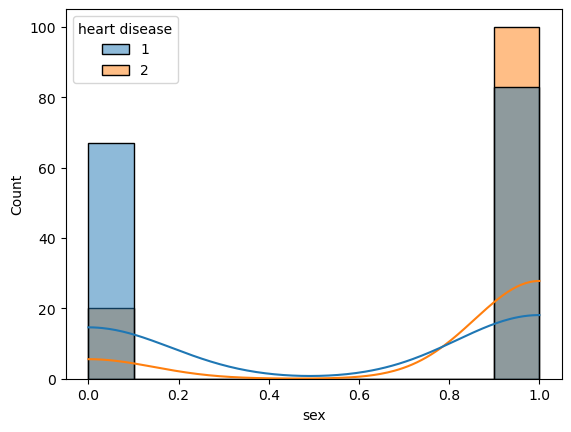

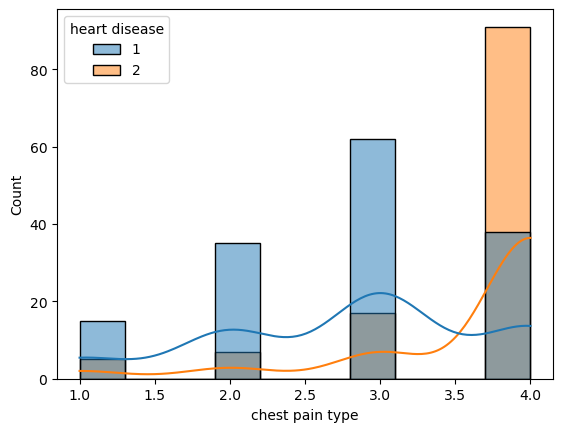

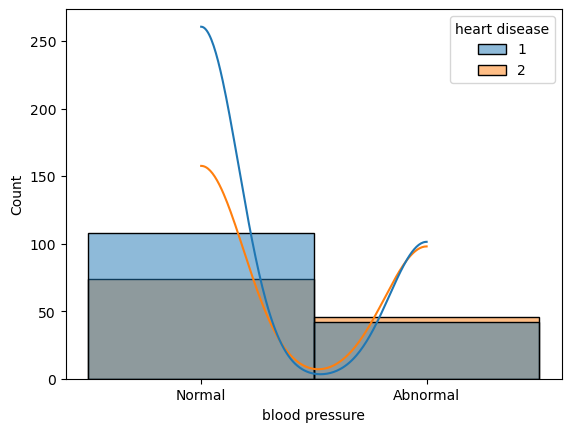

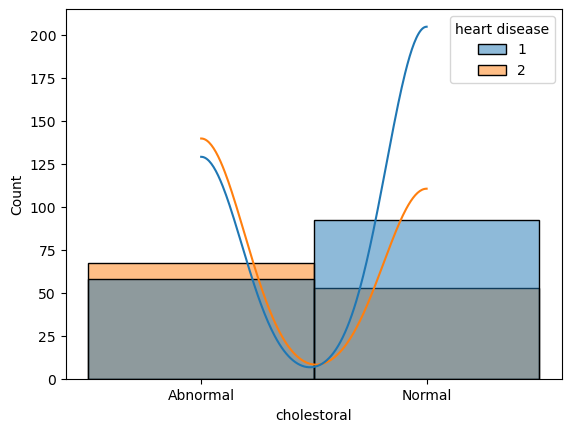

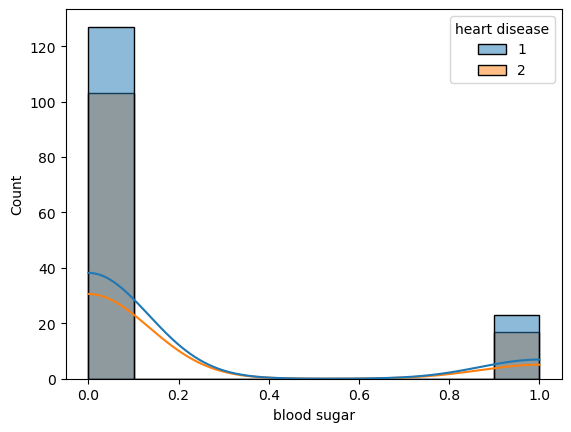

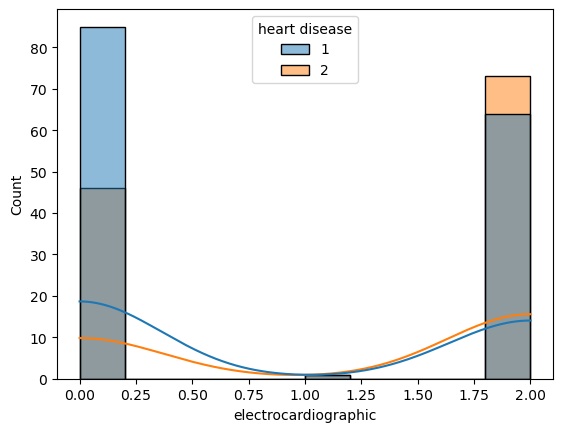

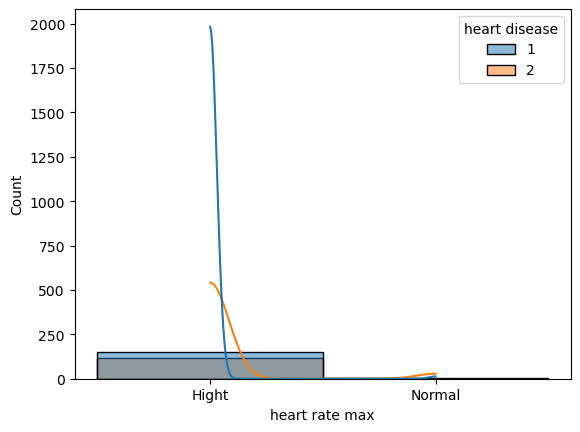

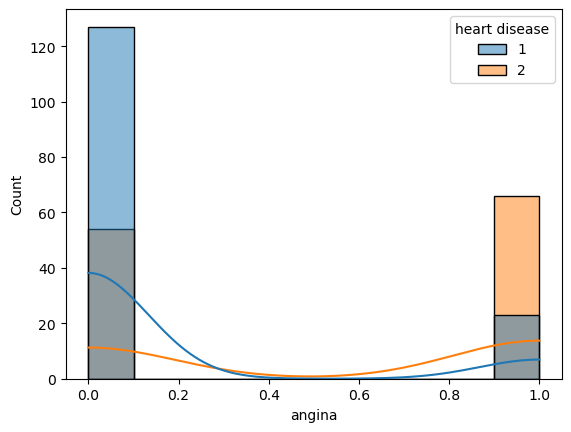

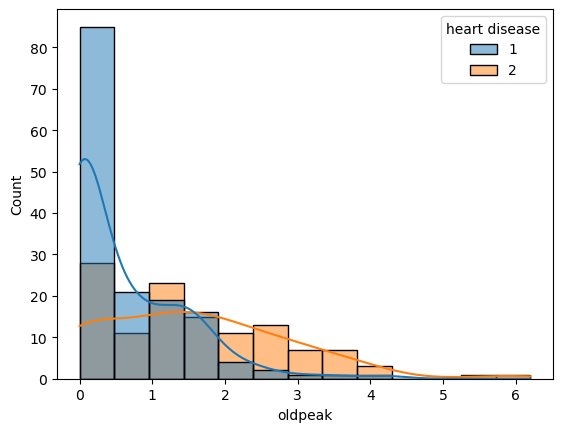

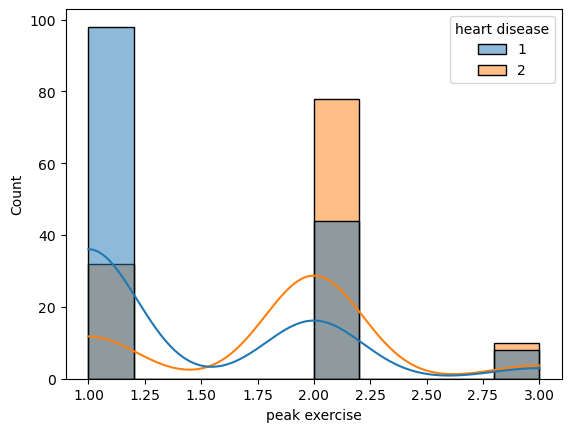

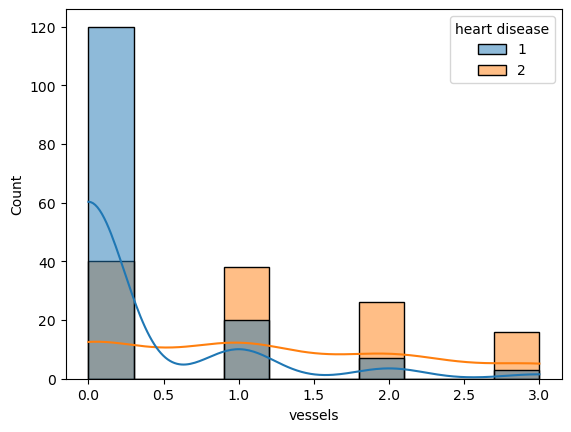

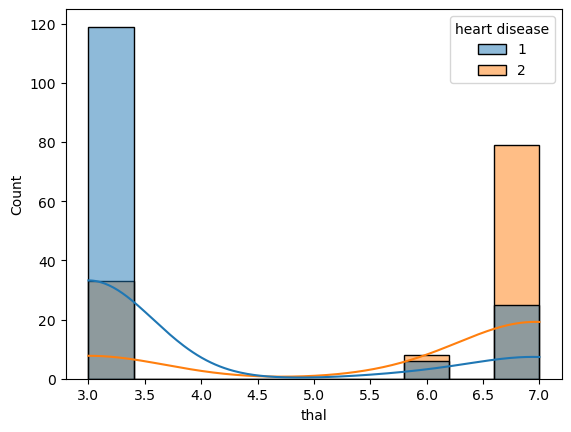

In [72]:
my_histplot(df, attributs, class_name)

Pairplot.

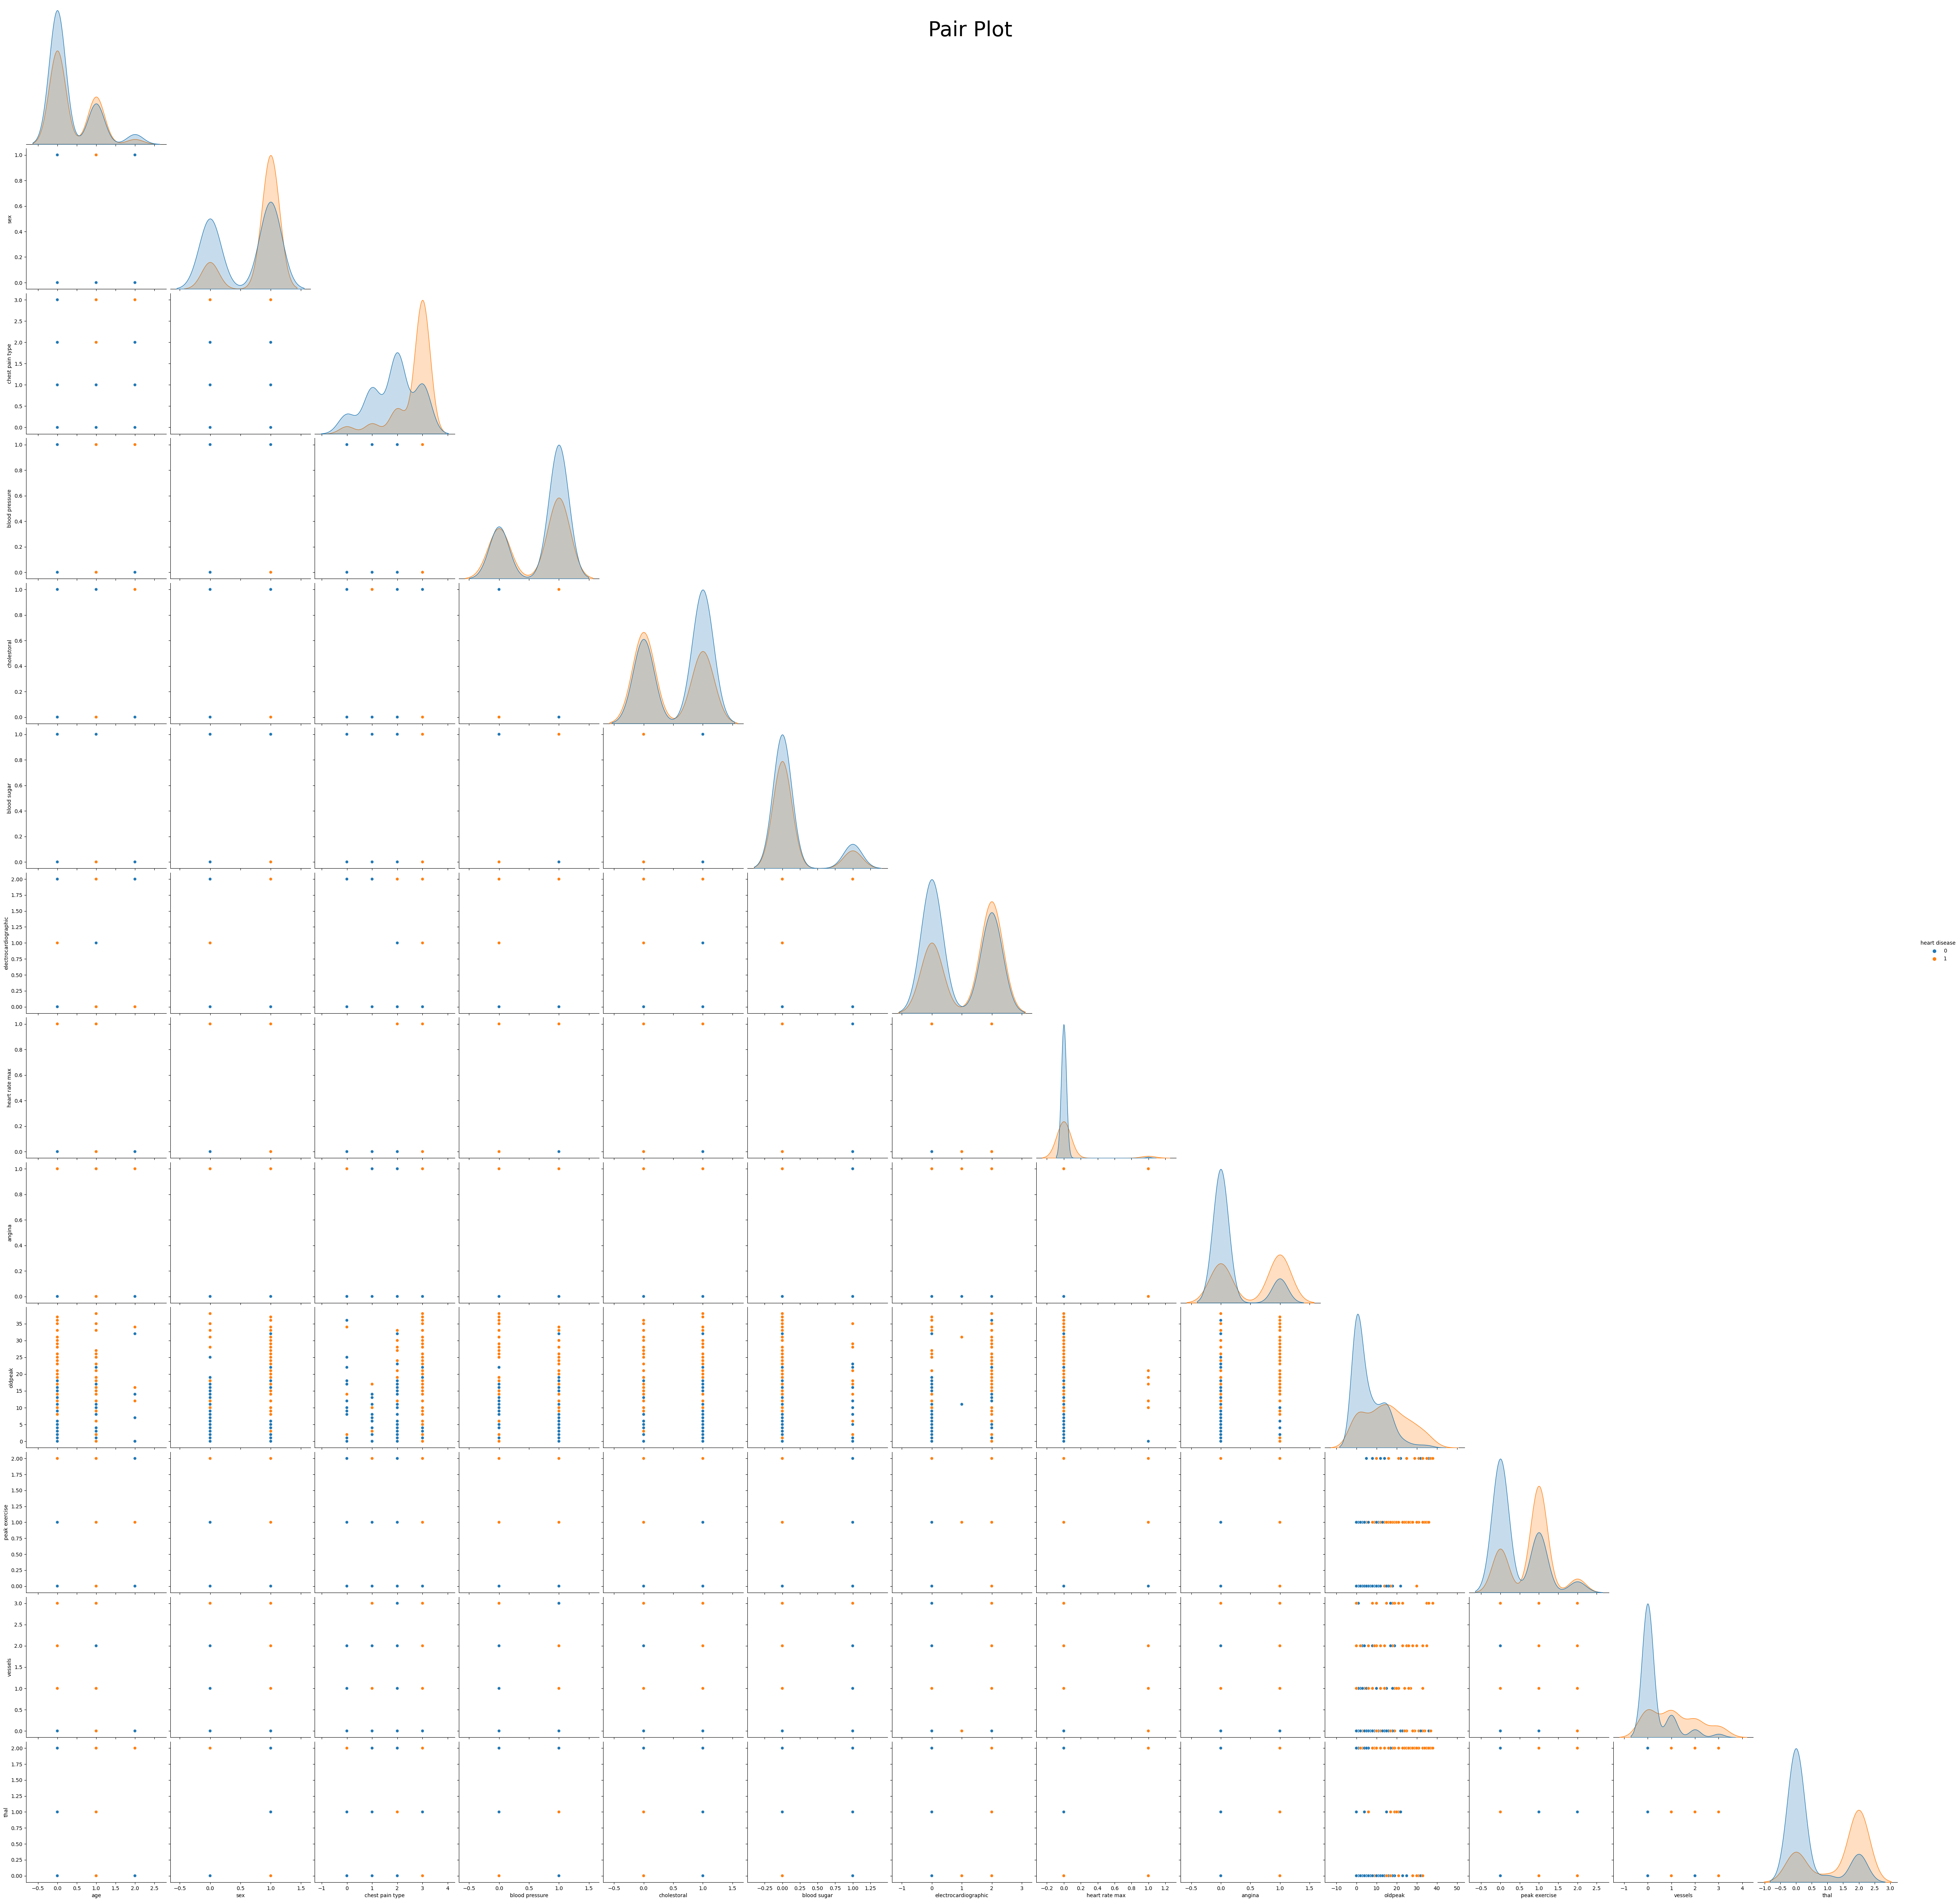

In [73]:
my_pairplot(df_prepro, class_name)

# *Oversampling* et *undersampling*.

In [74]:
# df_sample = sampling(df_prepro, attributs, class_name)
# df_sample

In [75]:
# my_pie(df_sample, class_name)

### Normalisation.

In [76]:
# df_prepro = normalisation(df_prepro, attributs)
# df_prepro

# *Features selection*.

In [77]:
reduct(df_prepro, class_name)

Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Un reduct trouvé !
Counter({11: 10, 10: 10, 12: 5, 9: 5, 8: 1})
Selection des reducts minimaux...


[['age',
  'sex',
  'chest pain type',
  'blood pressure',
  'electrocardiographic',
  'oldpeak',
  'vessels',
  'thal']]